In [1]:
import platform
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.nanops import bottleneck_switch

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [2]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/beam_test_25/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 5  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'zs_test_9-2-25'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'hv_410'

det_single = 'urw_inter'

# file_nums = list(range(0, 49))
# file_nums = list(range(0, 109))
file_nums = 'all'

noise_sigma = 5

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/processed/'


In [3]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [4]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')
det.load_dream_data(data_dir, None, noise_sigma, file_nums, chunk_size, save_waveforms=False, waveform_fit_func='parabola_vectorized')
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 6
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 800, 'resist_1': 410}
Checking file: CosTb_hv_410_datrun_250902_18H24_000_06_decoded.root
Checking file: CosTb_hv_410_datrun_250902_18H24_000_06_decoded_array.root
Reading in data...


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Read in data shape: (3315, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 78.43it/s]

Fitting time: 0.1727752685546875 s
Processed sub-chunk 1/1
Processed chunk 1/1
Getting hits...
Hits shape: (3315, 256)


/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:737: RuntimeWarning: All-NaN slice encountered
  event_max_amps = np.nanmax(self.data_amps, axis=1)


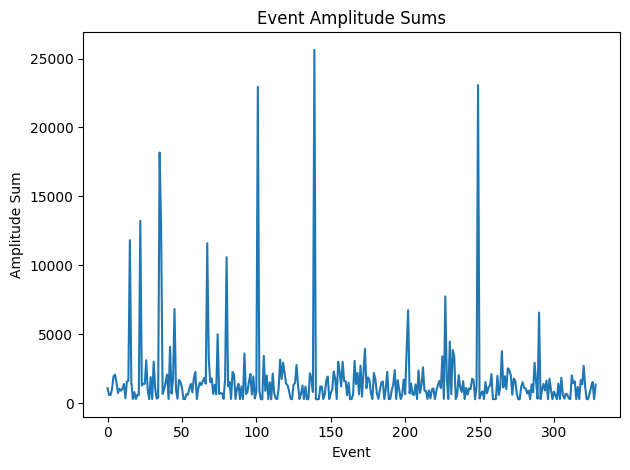

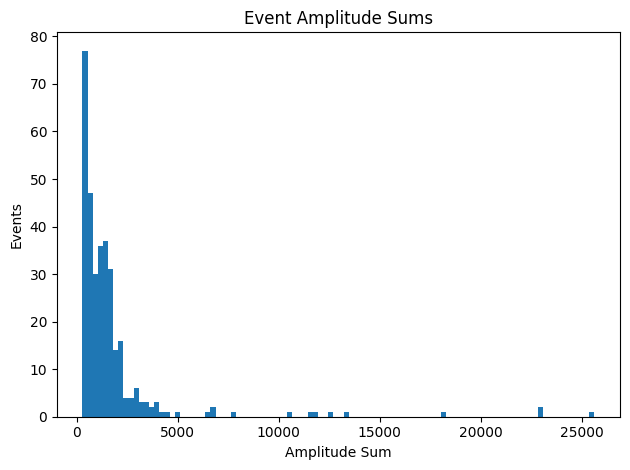

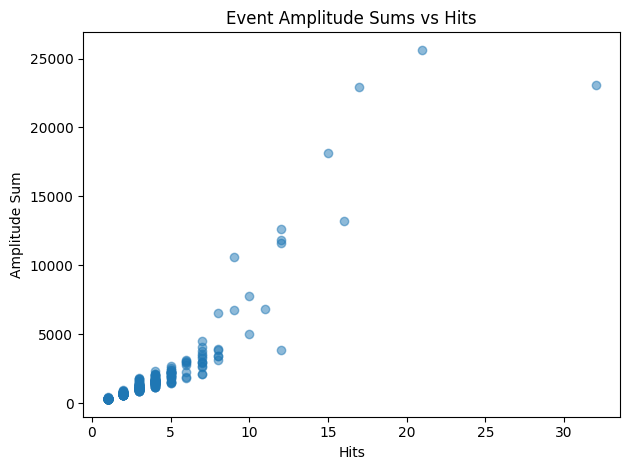

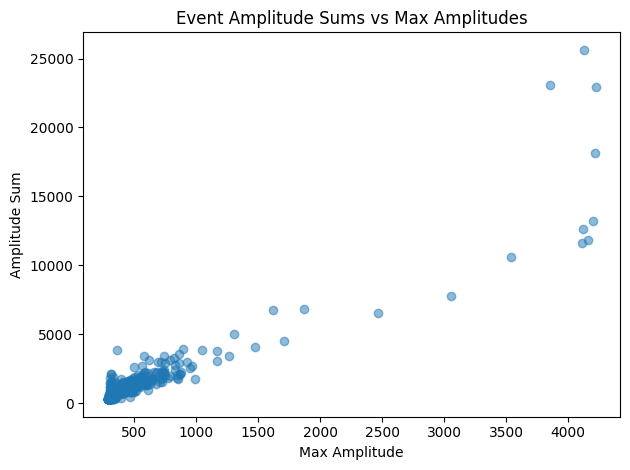

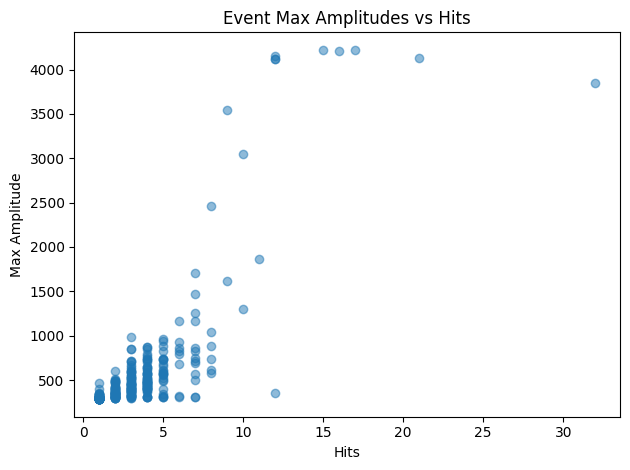

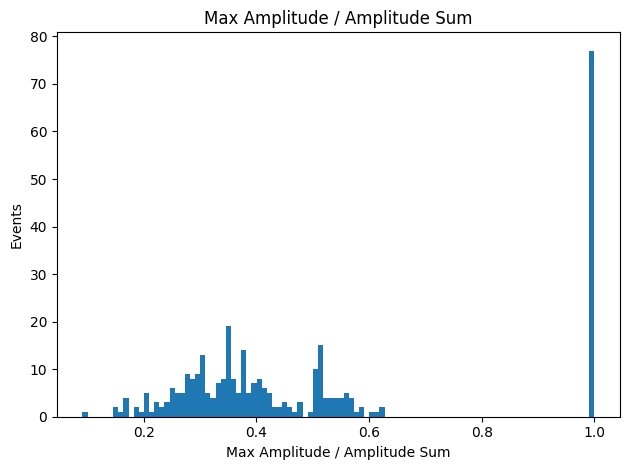

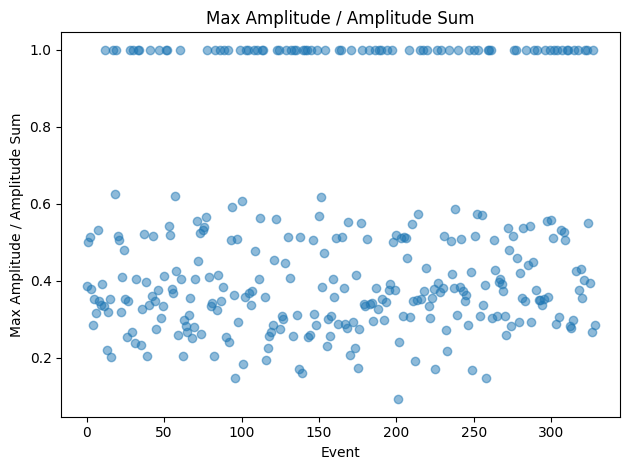

In [5]:
det.dream_data.plot_noise_metric()

Connector 1 Dead Strips: [51 52 61 62]
Connector 2 Dead Strips: [64 65 66]
Connector 3 Dead Strips: [130 132 133 134 135 136 137 174]
Connector 4 Dead Strips: [240 241 243 250 253]


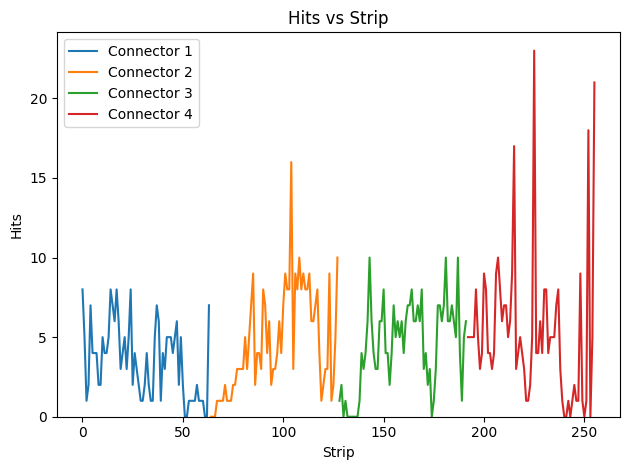

In [6]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

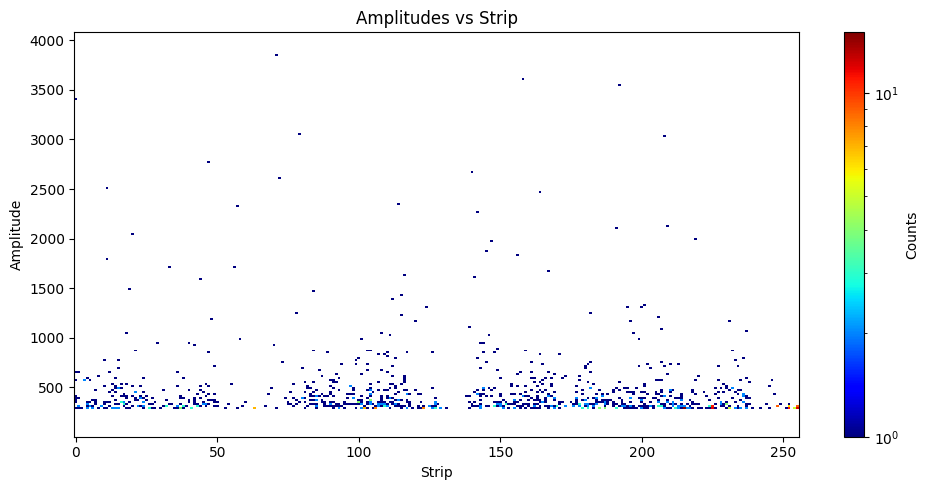

In [7]:
det.dream_data.plot_amplitudes_vs_strip()

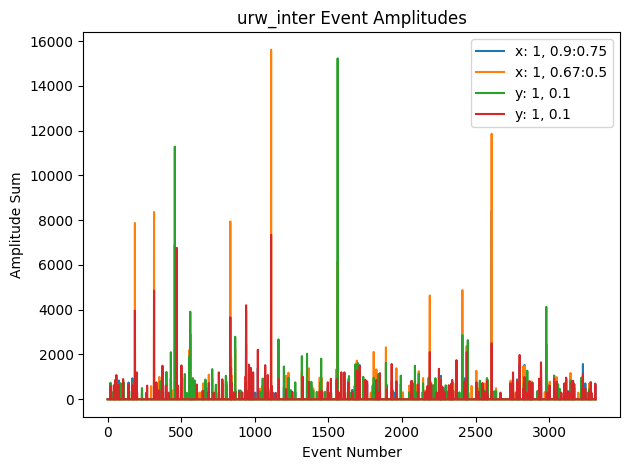

In [8]:
det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det.add_rotation(90, 'z')

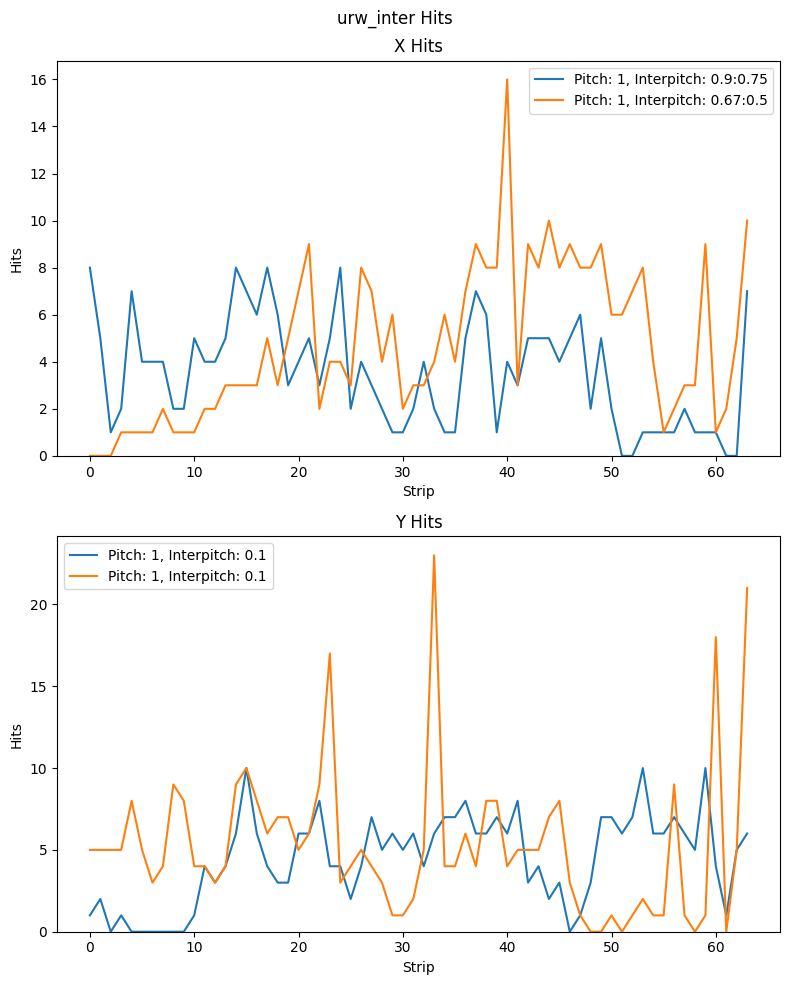

In [9]:
det.plot_hits_1d()

In [10]:
print(len(det.dream_data.hits))

3315


In [11]:
# for event_num in range(min(len(det.dream_data.hits), 2)):
#     det.plot_event_1d(event_num)
#     det.plot_event_2d(event_num)
#     det.dream_data.plot_waveforms(event_num)

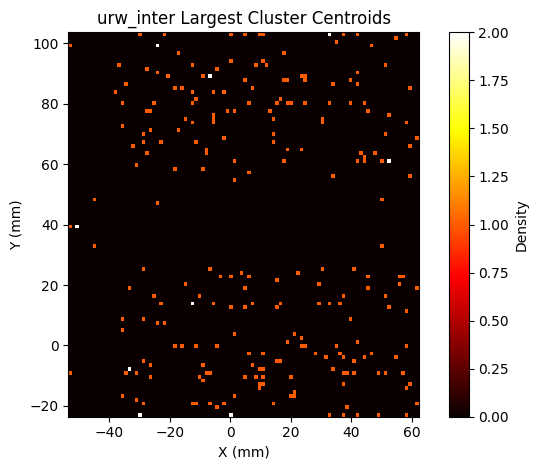

In [13]:
det.plot_centroids_2d_heatmap()

In [ ]:
plot_ray_hits_2d(det, ray_data)

In [ ]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2, grid_size=2)

In [ ]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2)

In [ ]:
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

New stuff above

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

In [ ]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
pitches, x_means, x_errs, y_means, y_errs = [], [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=-2)
    print(f'Rays in sub-detector {sub_det.sub_index}: {len(x_rays_in)}, total rays: {len(x_rays)}')
    x_mean, y_mean, x_err, y_err = sub_det.plot_cluster_sizes(event_nums=event_num_rays_in)
    pitches.append(sub_det.x_interpitch)
    x_means.append(x_mean)
    x_errs.append(x_err)
    y_means.append(y_mean)
    y_errs.append(y_err)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(pitches, x_means, yerr=x_errs, fmt='o', capsize=5, label='X')
ax.errorbar(pitches, y_means, yerr=y_errs, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
ax.plot(pitches, x_means, 'o', label='X')
ax.plot(pitches, y_means, 'o', label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [ ]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)

In [ ]:
scan_xs = np.linspace(-70, 60, 100 + 1)
scan_ys = np.linspace(-70, 60, 100 + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 2
min_events = 50
res_range = [160, 810]  # μm
mean_range = [-200, 210]  # μm

scan_resolutions_x, scan_means_x, events_x = get_circle_scan(np.array(x_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_x, scan_means_x, scan_xs, scan_ys, scan_events=events_x, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='X (Top) Spatial Resolution', mean_title='X (Top) Mean Residual', res_range=res_range, mean_range=mean_range)

In [ ]:
scan_resolutions_y, scan_means_y, events_y = get_circle_scan(np.array(y_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_y, scan_means_y, scan_xs, scan_ys, scan_events=events_y, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='Y (Bottom) Spatial Resolution', mean_title='Y (Bottom) Mean Residual', res_range=res_range, mean_range=mean_range)

In [ ]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_sizes_all, y_sizes_all, x_rays_cluster_sizes, y_rays_cluster_sizes = [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=0)
    x_sizes, y_sizes, ray_mask = sub_det.get_cluster_sizes(largest=True, event_nums=event_num_rays_in, return_ray_mask=True)
    x_sizes_all.extend(x_sizes)
    y_sizes_all.extend(y_sizes)
    x_rays_cluster_sizes.extend(x_rays_in[ray_mask])
    y_rays_cluster_sizes.extend(y_rays_in[ray_mask])
scan_resolutions_csx, scan_means_csx, events_csx = get_circle_scan(np.array(x_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, shape='square', gaus_fit=False, min_events=500, plot=False)
plot_2D_circle_scan(scan_resolutions_csx, scan_means_csx, scan_xs, scan_ys, scan_events=events_csx, radius=scan_radius, percentile_filter=(1, 95), plot='mean', unit_str='N strips', mean_title='X Cluster Size')

In [ ]:
scan_resolutions_csy, scan_means_csy, events_csy = get_circle_scan(np.array(y_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), shape='square', gaus_fit=False, plot=False)
plot_2D_circle_scan(scan_resolutions_csy, scan_means_csy, scan_xs, scan_ys, scan_events=events_csy, radius=scan_radius, percentile_filter=(1, 99), plot='mean', unit_str='N strips', mean_title='Y Cluster Size')

In [ ]:
det.dream_data.correct_for_fine_timestamps()

sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

In [ ]:
sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=600, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=600, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

In [ ]:
x_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, filter_times=False)
x_time_maxes, x_time_filter = det.dream_data.filter_time_maxes(x_time_maxes, return_mask=True)
y_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, filter_times=False)
y_time_maxes, y_time_filter = det.dream_data.filter_time_maxes(y_time_maxes, return_mask=True)
time_ray_event_mask_x = np.isin(event_num_rays, det.dream_data.event_nums[x_time_filter])
time_ray_event_mask_y = np.isin(event_num_rays, det.dream_data.event_nums[y_time_filter])
x_rays_timing_x, y_rays_timing_x = x_rays[time_ray_event_mask_x], y_rays[time_ray_event_mask_x]
x_rays_timing_y, y_rays_timing_y = x_rays[time_ray_event_mask_y], y_rays[time_ray_event_mask_y]

In [ ]:
scan_radius = 1
min_events = 30
res_range = [16, 68]  # ns
mean_range = [370, 410]  # ns
scan_time_resolutions_x, scan_time_means_x, events_time_x = get_circle_scan(np.array(x_time_maxes), np.array(x_rays_timing_x), np.array(y_rays_timing_x), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_x, scan_time_means_x, scan_xs, scan_ys, scan_events=events_time_x, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution X (Top) Strips', mean_title='Mean Time X (Top) Strips', res_range=res_range, mean_range=mean_range)

In [ ]:
scan_time_resolutions_y, scan_time_means_y, events_time_y = get_circle_scan(np.array(y_time_maxes), np.array(x_rays_timing_y), np.array(y_rays_timing_y), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_y, scan_time_means_y, scan_xs, scan_ys, scan_events=events_time_y, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution Y (Bottom) Strips', mean_title='Mean Time Y (Bottom) Strips', res_range=res_range, mean_range=mean_range)

In [ ]:
edge_cushion = 5 # mm
det_z = det.center[2]
for sub_det in det.sub_detectors:
    x_min_loc, x_max_loc = np.min(sub_det.x_pos), np.max(sub_det.x_pos)
    y_min_loc, y_max_loc = np.min(sub_det.y_pos), np.max(sub_det.y_pos)
    top_left, top_right = (x_min_loc, y_max_loc, det_z), (x_max_loc, y_max_loc, det_z)
    bottom_left, bottom_right = (x_min_loc, y_min_loc, det_z), (x_max_loc, y_min_loc, det_z)
    top_left, top_right = det.convert_coords_to_global(top_left), det.convert_coords_to_global(top_right)
    bottom_left, bottom_right = det.convert_coords_to_global(bottom_left), det.convert_coords_to_global(bottom_right)
    print(f'Sub-detector {sub_det.sub_index} corners:')
    print(f'Top Left: {top_left}, Top Right: {top_right}, Bottom Left: {bottom_left}, Bottom Right: {bottom_right}')
